In [175]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import random
from torch import nn, optim
import torch.nn.functional as F

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

# Load Data

In [350]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)
        
    global_mean = np.mean(inputs, axis = (0,1), keepdims = True)
    global_std = np.std(np.sqrt(inputs[:, :, 0]**2 + inputs[:, :, 0]**2))
    standard_inputs = (inputs - global_mean)/global_std
    
    standard_targets = None
    if split=="train" or split == 'val':
        standard_targets = (outputs - global_mean)/global_std
    
    return standard_inputs, standard_targets, global_mean, global_std

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs, self.global_mean, self.global_std = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx], self.global_mean, self.global_std)
            
        if self.transform:
            data = self.transform(data)

        return data

In [351]:
# intialize a dataset
def get_data_loader(city = 'austin', batch_size = 20):
    train_dataset  = ArgoverseDataset(city = city, split = 'train')
    val_dataset = ArgoverseDataset(city = city, split = 'val')

    train_loader = DataLoader(train_dataset,batch_size=batch_size)
    val_loader = DataLoader(val_dataset,batch_size=batch_size)
    return train_dataset, val_dataset, train_loader, val_loader

In [352]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'austin', batch_size = 64)
len(val_dataset)

8609

In [353]:
len(train_dataset)

34432

In [354]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Model

In [203]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate):
        
        super(Encoder, self).__init__()

        self.lstm = nn.LSTM(input_size = input_dim, 
                            hidden_size = hidden_dim, 
                            num_layers= num_layers, 
                            dropout = dropout_rate, 
                            batch_first = True)
        
        
    def forward(self, source):
        
        # hidden = (h, c)
        # h, c: num_layers x bz x  hid_dim
        # outputs: bz x input_length x hid_dim
        outputs, hidden = self.lstm(source)
        
        return outputs, hidden
    
class AttnDecoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers, dropout_rate):

        super(AttnDecoder, self).__init__()

        # Learn the attention scores
        self.attn = nn.Linear(hidden_dim + output_dim, 50)
        
        # Learn the final input to the decoder 
        self.attn_combine = nn.Linear(hidden_dim + output_dim, hidden_dim)
        
        # Decoder LSTM
        self.lstm = nn.LSTM(input_size = hidden_dim, 
                            hidden_size = hidden_dim, 
                            num_layers= num_layers, 
                            dropout = dropout_rate, 
                            batch_first = True)
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
      
    def forward(self, x, hidden, encoder_outputs):
        
        h = hidden[0]
        h = h.transpose(0,1).reshape(h.shape[1], -1)
        
        # Compute Attention Scores
        attn_weights = F.softmax(self.attn(torch.cat([x, h], 1)), dim =1)
        
        # Calculate weighted sum of encoder hidden states     
        attn_applied = torch.einsum("bl,blh->bh", attn_weights, encoder_outputs)
        
        x = torch.cat((x, attn_applied), dim = 1)
        x = self.attn_combine(x).unsqueeze(1)
        x = F.relu(x)
        
        output, decoder_hidden= self.lstm(x, hidden)  
        prediction = self.output_layer(output.float())
        
        return prediction.squeeze(1), decoder_hidden
    
class Seq2Seq(nn.Module):
    def __init__(self, input_dim = 2, output_dim = 2, hidden_dim = 128, num_layers = 1, dropout_rate = 0):
        
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, num_layers, dropout_rate)
        self.decoder = AttnDecoder(output_dim, hidden_dim, num_layers, dropout_rate)

    def forward(self, source, target_length = 60):

        batch_size = source.size(0) 
        input_length = source.size(1) 
        
        encoder_outputs, concat_hidden = self.encoder(source)
        
        # the last encoder hidden state is used as initial hidden state of the decoder
        decoder_hidden = concat_hidden
        # the first input to the decoder is last input position
        decoder_output = source[:,-1]
    
        
        outputs = torch.zeros(batch_size, target_length, 2)
        for t in range(target_length):    
            decoder_output, decoder_hidden = self.decoder(decoder_output, decoder_hidden, encoder_outputs)
            outputs[:,t] = decoder_output   
        return outputs

In [204]:
class LSTM(nn. Module):
    def __init__(self, batch_size = 64, hidden_size = 128, num_layers = 1):
        super().__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size = 2, hidden_size = self.hidden_size, num_layers = self.num_layers, batch_first = True)
        self.FC = nn.Linear(self.hidden_size, 2)
        

    def forward(self, x, hidden):
        
        x = x.float()
        out, hidden = self.lstm(x, hidden)
        
        out = self.FC(out)
        
        return out, hidden
    
    def init_hidden(self,batch_size):
        
        weights = next(self.parameters()).data
        
        hidden = (weights.new(self.num_layers, batch_size, self.hidden_size).zero_().float(), # (num_layers, batch_size)
                  weights.new(self.num_layers, batch_size, self.hidden_size).zero_().float())
        
        return hidden

In [321]:
def train_epochs(model, train_dataset, train_loader, loss_func, opt, batch_size, epochs = 10):
    train_losses = []
    for epoch in range(epochs):

        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader):
            inp, out, global_mean, global_std = sample_batch
            
            inp = inp.float().cuda() 
            out = out.float()
            out = (out*global_std[0] + global_mean[0]).cuda()
                
            # prediction
            preds = model(inp)
            preds = (preds*global_std[0] + global_mean[0]).cuda()
            loss = loss_func(preds, out)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()

        print('epoch {} trian loss: {}'.format(epoch, total_loss / len(train_dataset)))
        train_losses.append(total_loss / (len(train_dataset)))
    return train_losses

In [331]:
def val_loss(model, city, batch_size):
    train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = city, batch_size = batch_size)
    
    # model, optimizer, loss
    model = model
    opt = optim.Adam(model.parameters(), lr=1e-3)
    loss_func = nn.MSELoss()
    
    val_loss = 0
    for i_batch, sample_batch in enumerate(val_loader):
        inp, out, global_mean, global_std = sample_batch
            
        inp = inp.float().cuda() 
        out = out.float()
        out = (out*global_std[0] + global_mean[0]).cuda()
                
        # prediction
        preds = model(inp)
        preds = (preds*global_std[0] + global_mean[0]).cuda()
        loss = loss_func(preds, out)

        val_loss += loss.item()
    print('val loss: {}'.format(val_loss / len(val_dataset)))

In [322]:
def train_city(city, batch_size, epochs, model):
    # data loader
    train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = city, batch_size = batch_size)
    
    # model, optimizer, loss
    model_encdoc = model.to(device)
    opt = optim.Adam(model_encdoc.parameters(), lr=1e-3)
    loss_func = nn.MSELoss()
    
    # train
    train_losses = train_epochs(model_encdoc, train_dataset, train_loader, loss_func, opt, batch_size, epochs = epochs)
    
    # evaluate
    # val_loss(model_encdoc, val_loader, loss_func, opt)
    return model_encdoc, train_losses

# Training

epoch 0 trian loss: 771.9465253388217
epoch 1 trian loss: 27.5260844552529
epoch 2 trian loss: 23.79507868586611
epoch 3 trian loss: 18.695780237365557
epoch 4 trian loss: 15.434553683977514
epoch 5 trian loss: 13.267568638114913
epoch 6 trian loss: 12.128549525856313
epoch 7 trian loss: 11.602623783947436
epoch 8 trian loss: 11.321472505358656
epoch 9 trian loss: 11.12040730137348
epoch 10 trian loss: 10.87834632547121
epoch 11 trian loss: 10.463098245112878
epoch 12 trian loss: 10.244024978755249
epoch 13 trian loss: 10.173022949982407
epoch 14 trian loss: 9.971663438448777
epoch 15 trian loss: 9.736035853787591
epoch 16 trian loss: 9.52809660507221
epoch 17 trian loss: 9.403060357403923
epoch 18 trian loss: 9.220080607323125
epoch 19 trian loss: 9.09224075365078
val loss: 3.733585090924973


Text(0, 0.5, 'MSE')

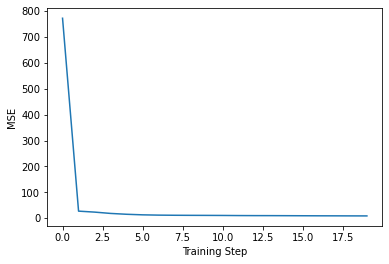

In [355]:
model = Seq2Seq().to(device)
model_austin, train_losses = train_city('austin', batch_size = 64, epochs = 20, model = model)
val_loss(model_austin, 'austin', batch_size = 128)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

epoch 0 trian loss: 2955.1536338510737
epoch 1 trian loss: 58.15157526889891
epoch 2 trian loss: 40.686662289336674
epoch 3 trian loss: 32.94496725812987
epoch 4 trian loss: 48.4261972884625
epoch 5 trian loss: 35.08503272346669
epoch 6 trian loss: 31.942897894671326
epoch 7 trian loss: 27.35823584779075
epoch 8 trian loss: 24.35159852512478
epoch 9 trian loss: 22.72248107495414
epoch 10 trian loss: 18.728010170116242
epoch 11 trian loss: 16.832238540368184
epoch 12 trian loss: 18.39212256905502
epoch 13 trian loss: 15.947201880055019
epoch 14 trian loss: 15.882045148632802
epoch 15 trian loss: 15.356186335249463
epoch 16 trian loss: 13.483183938118833
epoch 17 trian loss: 13.955696188708293
epoch 18 trian loss: 13.035355266727016
epoch 19 trian loss: 13.089638954778831
val loss: 4.258082879030652


Text(0, 0.5, 'MSE')

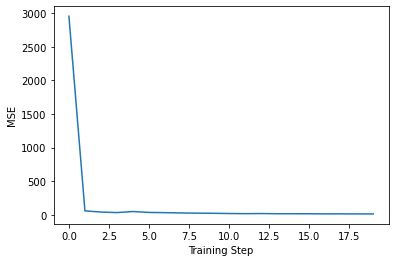

In [356]:
# miami
model = Seq2Seq().to(device)
model_miami, train_losses = train_city('miami', batch_size = 64, epochs = 20, model = model)
val_loss(model_miami, 'miami', batch_size = 128)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

epoch 0 trian loss: 982.8941620039109
epoch 1 trian loss: 21.13256803953033
epoch 2 trian loss: 20.47325517305716
epoch 3 trian loss: 17.802934559038253
epoch 4 trian loss: 16.061498548638582
epoch 5 trian loss: 14.211337002419837
epoch 6 trian loss: 11.570227556410975
epoch 7 trian loss: 10.417493629136949
epoch 8 trian loss: 9.678095133265368
epoch 9 trian loss: 9.143920770011206
epoch 10 trian loss: 8.966337667641561
epoch 11 trian loss: 9.131320285126904
epoch 12 trian loss: 8.411261314860225
epoch 13 trian loss: 8.140540188906263
epoch 14 trian loss: 8.120197902335418
epoch 15 trian loss: 7.998143035359373
epoch 16 trian loss: 8.378346774519738
epoch 17 trian loss: 7.763634519974557
epoch 18 trian loss: 7.545778917885619
epoch 19 trian loss: 7.376370640109489
val loss: 3.287742579029682


Text(0, 0.5, 'MSE')

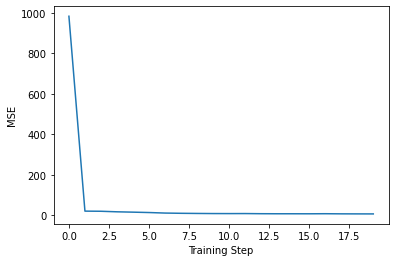

In [357]:
# pittsburgh
model = Seq2Seq().to(device)
model_pittsburgh, train_losses = train_city('pittsburgh', batch_size = 64, epochs = 20, model = model)
val_loss(model_pittsburgh, 'pittsburgh', batch_size = 128)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

epoch 0 trian loss: 9156.50946071197
epoch 1 trian loss: 136.02241723146187
epoch 2 trian loss: 66.41456202103535
epoch 3 trian loss: 60.37098456834794
epoch 4 trian loss: 58.85029633580573
epoch 5 trian loss: 53.813064913438936
epoch 6 trian loss: 53.86217995498196
epoch 7 trian loss: 52.634431285363064
epoch 8 trian loss: 53.97426525768244
epoch 9 trian loss: 49.96446409500567
epoch 10 trian loss: 49.39338606068769
epoch 11 trian loss: 47.7968379540383
epoch 12 trian loss: 46.58322900213832
epoch 13 trian loss: 45.39816327207082
epoch 14 trian loss: 44.312754509758285
epoch 15 trian loss: 42.476770193191705
epoch 16 trian loss: 40.71073150581863
epoch 17 trian loss: 38.42659312747595
epoch 18 trian loss: 35.07825334696101
epoch 19 trian loss: 34.534306564913365
val loss: 21.06448599715925


Text(0, 0.5, 'MSE')

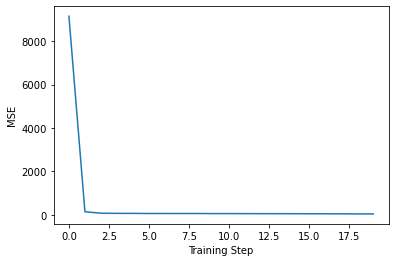

In [358]:
# dearborn
model = Seq2Seq().to(device)
model_dearborn, train_losses = train_city('dearborn', batch_size = 64, epochs = 20, model = model)
val_loss(model_dearborn, 'dearborn', batch_size = 128)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

epoch 0 trian loss: 1515.771793895395
epoch 1 trian loss: 28.03637901656461
epoch 2 trian loss: 25.450198033104474
epoch 3 trian loss: 23.87036220123735
epoch 4 trian loss: 21.968443054679383
epoch 5 trian loss: 20.960524246903095
epoch 6 trian loss: 19.39337229689794
epoch 7 trian loss: 17.802783823708022
epoch 8 trian loss: 16.833336725258928
epoch 9 trian loss: 15.152955555407102
epoch 10 trian loss: 14.864991341651479
epoch 11 trian loss: 11.615988443354965
epoch 12 trian loss: 11.953061329893137
epoch 13 trian loss: 10.750030987280114
epoch 14 trian loss: 10.681509037418643
epoch 15 trian loss: 9.917282427792072
epoch 16 trian loss: 10.242492919785773
epoch 17 trian loss: 9.844125394057965
epoch 18 trian loss: 9.82994219548778
epoch 19 trian loss: 9.727742975299199
val loss: 4.29700710522984


Text(0, 0.5, 'MSE')

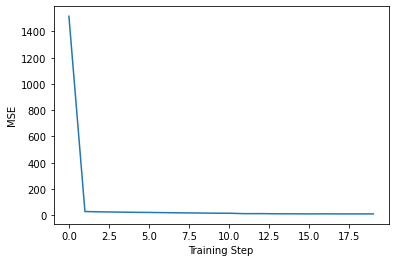

In [359]:
# washington_dc
model = Seq2Seq().to(device)
model_washington_dc, train_losses = train_city('washington-dc', batch_size = 64, epochs = 20, model = model)
val_loss(model_washington_dc, 'washington-dc', batch_size = 128)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

In [360]:
# palo_alto
model = Seq2Seq().to(device)
model_palo_alto, train_losses = train_city('palo-alto', batch_size = 64, epochs = 20, model = model)
val_loss(model_palo_alto, 'palo-alto', batch_size = 128)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

epoch 0 trian loss: 2160.0657149576186
epoch 1 trian loss: 49.726977294445305
epoch 2 trian loss: 36.5888130684446
epoch 3 trian loss: 34.73073186214565
epoch 4 trian loss: 32.70857544541502


KeyboardInterrupt: 

In [314]:
for i_batch, sample_batch in enumerate(train_loader):
    inp, out, global_mean, global_std = sample_batch
            
    inp = inp.float().cuda() 
    out = out.float()
    print(global_std)
    out = (out*global_std[0] + global_mean[0]).cuda()
                
            # prediction
    preds = model(inp).cuda()
    inverse_preds = (pred*global_std[0] + global_mean[0]).cuda()
    
    loss = loss_func(inverse_preds, out)
    print(loss/len(inp))
    break

tensor([1583.1328, 1583.1328, 1583.1328, 1583.1328, 1583.1328, 1583.1328,
        1583.1328, 1583.1328, 1583.1328, 1583.1328], dtype=torch.float64)
tensor(560652.4120, device='cuda:0', dtype=torch.float64)


# Make Predictions

In [340]:
cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
models = [model_austin, model_miami, model_pittsburgh, model_dearborn, model_washington_dc, model_palo_alto]

In [341]:
def predict_test(city, model):
    standard_inputs, standard_targets, global_mean, global_std = get_city_trajectories(city = city, split = 'test')
    standard_inputs = torch.from_numpy(standard_inputs).float().cuda()
    pred = model_austin(standard_inputs).detach()
    print(pred.shape)
    inverse_preds = (pred*global_std + global_mean)
    inverse_preds = inverse_preds.reshape(-1, 120)
    return pd.DataFrame(inverse_preds.numpy())

In [342]:
columns =['ID'] + ['v'+str(i) for i in range(120)]

In [343]:
def predict_all(cities, models):
    out = predict_test(cities[0], models[0]).reset_index()
    out.columns = columns
    out['ID'] = out['ID'].astype(str) + '_' + cities[0]
    
    for city, model in zip(cities[1:], models[1:]):
        temp = predict_test(city, model).reset_index()
        temp.columns = columns
        temp['ID'] = temp['ID'].astype(str) + '_' + city
        out = pd.concat([out, temp])
    
    return out        

In [344]:
test_output = predict_all(cities, models)

torch.Size([6325, 60, 2])
torch.Size([7971, 60, 2])
torch.Size([6361, 60, 2])
torch.Size([3671, 60, 2])
torch.Size([3829, 60, 2])
torch.Size([1686, 60, 2])


In [345]:
test_output

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,9.587603,-582.773312,-4.676252,-572.883664,-2.126020,-576.943204,-3.786237,-575.938779,-6.341230,...,-8.490033,-572.470609,-8.490033,-572.470578,-8.490033,-572.470609,-8.489911,-572.470639,-8.490033,-572.470578
1,1_austin,-336.183393,10.828860,-344.138837,16.278812,-340.177778,4.852969,-339.410077,3.762393,-340.220990,...,-340.689496,4.523563,-340.689496,4.523563,-340.689496,4.523685,-340.689496,4.523685,-340.689496,4.523563
2,2_austin,59.663653,-264.203854,54.926776,-247.388669,59.517413,-254.893308,59.192034,-255.729672,57.812884,...,58.210467,-253.223141,58.210467,-253.223141,58.210467,-253.223141,58.210467,-253.223141,58.210467,-253.223141
3,3_austin,-111.575177,1777.724734,-100.332746,1781.013797,-103.763959,1775.614871,-107.080243,1774.445682,-108.572309,...,-106.525800,1772.231082,-106.525739,1772.231326,-106.525800,1772.231082,-106.525739,1772.231082,-106.525739,1772.231082
4,4_austin,1144.510760,-655.563535,1182.343280,-639.340039,1185.631182,-635.764478,1185.460528,-635.585416,1185.999163,...,1191.647235,-638.669492,1191.647235,-638.669492,1191.647235,-638.669492,1191.647235,-638.669507,1191.647235,-638.669492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,1681_palo-alto,-1404.128850,-456.584702,-1408.924871,-488.509507,-1397.219609,-474.906235,-1400.595220,-474.243759,-1408.439946,...,-1422.831792,-483.260849,-1422.831792,-483.260849,-1422.831792,-483.260849,-1422.831792,-483.260849,-1422.831792,-483.260849
1682,1682_palo-alto,118.595698,-36.529038,112.941462,-27.441025,118.433284,-0.421006,120.554072,-0.579087,118.409541,...,114.212703,-5.596909,114.212703,-5.596909,114.212703,-5.596909,114.212642,-5.596909,114.212703,-5.596909
1683,1683_palo-alto,-1434.108892,2157.523269,-1434.535588,2157.378067,-1432.972783,2152.016189,-1432.524480,2152.191971,-1432.806951,...,-1432.895574,2152.044693,-1432.895635,2152.044693,-1432.895635,2152.044693,-1432.895635,2152.044693,-1432.895635,2152.044693
1684,1684_palo-alto,989.571895,1305.225334,1056.675776,1328.099647,1047.561641,1323.773407,1045.085566,1320.708923,1039.849971,...,1029.502070,1328.221626,1029.501948,1328.221626,1029.502070,1328.221626,1029.502070,1328.221611,1029.502070,1328.221595


In [346]:
test_output.to_csv('test_output.csv', index=False)

# Visualization

In [361]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'austin', batch_size = 10)

torch.Size([10, 60, 2])


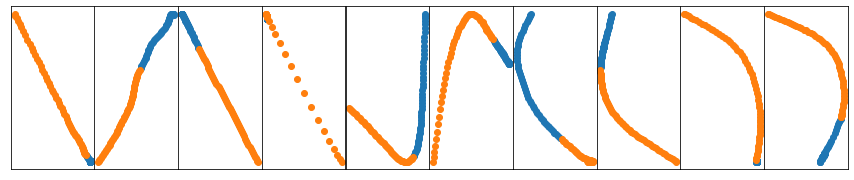

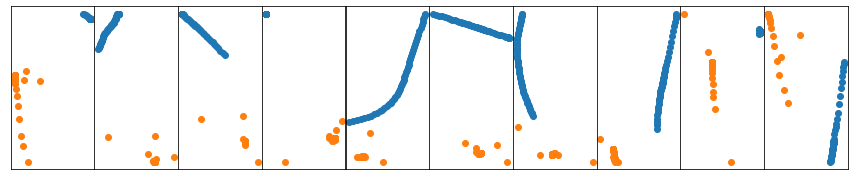

In [362]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    if i_batch < 6: continue
    inp, out, global_mean, global_std = sample_batch
    inp = inp.float().cuda()
    out = out.float().cuda()
    
    pred = model_austin(inp).detach()
    #print(global_std[0])
    #inverse_preds = pred*global_std[0] + global_mean[0]
    #inp = inp.cpu()*global_std[0] + global_mean[0]
    #out = out.cpu()*global_std[0] + global_mean[0]
    
    show_sample_batch([inp.cpu(), out.cpu()])
    show_sample_batch([inp.cpu(), pred.cpu()])
    print(pred.shape)
    break